<a href="https://colab.research.google.com/github/EAakiyama3104/python_lecture/blob/master/%5BPython%E8%AC%9B%E5%BA%A7%5D%E7%AC%AC3%E5%9B%9ESpotify_API%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Spotify API とは

* Spotify 上の音楽データを提供しているWeb API
* Spotify上のアーティスト情報や曲の情報などを取得できる

詳細: https://developer.spotify.com/documentation/web-api/reference/

Spotify API の特徴

![代替テキスト](https://cdn-ssl-devio-img.classmethod.jp/wp-content/uploads/2017/12/spotify-api-overview.png)

* Spotify URIやSpotify IDなど、Spotify特有のパラメータ情報をリクエスト、レスポンス時に扱うことがあります。
* レート制限に引っかかるとステータスコード429が返却される。これが返ってきた場合は、Retry-Afterヘッダーの値を確認し、そこに記載されている秒の間はAPIをコールすることができない。

* レスポンスデータは、JSON Object形式で取得します。

* タイムスタンプはUTC zero offset形式（YYYY-MM-DDTHH:MM:SSZ）

* 一部のAPIではページネーションをサポート（offset、limitパラメータで指定）

* 多くのAPIでは、クライアント側でレスポンスデータのキャッシュを行うためのヘッダー情報が付与される。

* レスポンスステータスコードは、RFC 2616 と RFC 6585に則って2xx、3xx、4xx、5xxを返す。

* レスポンスデータのエラー表現には、下記2種類のフォーマットを使用する。

  * Authentication Error Object
  * Regular Error Object
*APIをコールするにはOAuthアクセストークンが必要。

認証方法の種類

![代替テキスト](https://cdn-ssl-devio-img.classmethod.jp/wp-content/uploads/2017/12/Obtaining-Authorization.png)

* App Authorization
  * システム（Spotify）が、クライアントアプリケーションに、Spotify Platform (APIs, SDKs and Widgets)へアクセスすることを許可します。
* User Authorization
  * エンドユーザー（Spotifyのエンドユーザー）が、クライアントアプリケーションに、エンドユーザーが所有するデータへアクセスすることを許可します。

アプリが認証の許可を得るための3つの方法


* Refreshable user authorization: Authorization Code
  * このフローでは、エンドユーザーはクライアントアプリケーションがリソースへアクセスすることを1度だけ許可します。そのため長期間稼働させるアプリケーションに適しています。 アプリケーションにはリフレッシュ可能なアクセストークンを提供されます。ちなみにトークン交換には秘密鍵の送信が含まれるため、ブラウザやモバイルアプリなどのクライアントからではなく、バックエンドサービスなどの安全な場所でこれを実行します。
* Temporary user authorization: Implicit Grant
  * このフローは、JavaScriptを使用するため、リソース所有者のブラウザで実行されるクライアントアプリケーション向けです。サーバー側のコードを使用する必要はありません。リクエストのレート制限は改善されていますが、リフレッシュトークンは提供されていません。このフローはRFC-6749で定義されています。
* Refreshable app authorization: Client Credentials Flow
  * このフローは、サーバー間認証で使用されます。エンドユーザー情報にアクセスしないエンドポイントのみにアクセスが可能です。
  * このセミナーではこの認証方法を使用

## アカウントを作る

1. https://www.spotify.com/ にアクセスしてアカウントを作る。
2. https://developer.spotify.com/my-applications に行ってログイン
3. Create an Application に Application Name と Description を入れる
4. Are you developing a commercial integration? と聞かれたら、この講座では NO を選択
5. チェックボックスをオンにして Submit
6. Client ID と Client Secret メモしておく。APIを呼ぶ際に使います。

## Spotipyのインストール

Spotipy とは、Spotify APIを呼ぶためのPythonライブラリ

* HTTPリクエストを送る操作をライブラリ内で行っているため、リクエストを意識せずに使うことができる
* pip install spotipy でインストール

In [0]:
!pip install spotipy

In [0]:
import spotipy

spotipy.Spotify クラスがAPIへ様々なリクエストを送る

https://spotipy.readthedocs.io/en/latest/#module-spotipy.client

In [0]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

CLIENT_ID = "ここにクライアントIDを入力"
CLIENT_SECRET = "ここにクライアントシークレットを入力"

# 認証情報をセット
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
# 認証情報を元に、APIクライアントを作成
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

プレイリストを取得

公式リファレンス: https://developer.spotify.com/documentation/web-api/reference/playlists/get-list-users-playlists/

Spotipyリファレンス: https://spotipy.readthedocs.io/en/latest/#spotipy.client.Spotify.user_playlist

例: プレイリストのタイトルとURLを取得する

In [0]:
# Spotify 公式のプレイリストから2つ取得
playlists = sp.user_playlists('spotify',limit=2)
# 辞書形式で返却される
type(playlists)

dict

In [0]:
birdy_uri = 'spotify:artist:2WX2uTcsvV5OnS0inACecP'
spotify = spotipy.Spotify()

results = sp.artist_albums(birdy_uri, album_type='album')
albums = results['items']
while results['next']:
  results = sp.next(results)
  albums.extend(results['items'])

for album in albums:
  print(album['name'])

Beautiful Lies
Beautiful Lies
Beautiful Lies (Deluxe)
Beautiful Lies (Deluxe)
Fire Within
Fire Within
Fire Within (Deluxe)
Fire Within (Deluxe)
Fire Within (Deluxe)
Live in London
Birdy
Birdy
Birdy
Birdy
Birdy (Deluxe Version)


## 必要なライブラリを読み込み

In [0]:
import pandas as pd
import seaborn as sns

ジャンル情報を取得

In [0]:
pd.DataFrame(sp.recommendation_genre_seeds())

,genres
0,acoustic
1,afrobeat
2,alt-rock
3,alternative
4,ambient
...,...
121,trance
122,trip-hop
123,turkish
124,work-out


特定のジャンルの曲を取得

/search API を用いる

* 公式リファレンス: https://developer.spotify.com/documentation/web-api/reference/search/search/
* spotipy のリファレンス: https://spotipy.readthedocs.io/en/latest/#spotipy.client.Spotify.search

In [0]:
# ジャンルで検索
search_genre = sp.search(q='genre:acoustic', type='track', offset=0, limit=1)
pprint(search_genre)

In [0]:
# tracks > items から検索結果を取得
pprint(search_genre['tracks']['items'])

[{'album': {'album_type': 'single',
            'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5D3muNJhYYunbRkh3FKgX0'},
                         'href': 'https://api.spotify.com/v1/artists/5D3muNJhYYunbRkh3FKgX0',
                         'id': '5D3muNJhYYunbRkh3FKgX0',
                         'name': 'Chord Overstreet',
                         'type': 'artist',
                         'uri': 'spotify:artist:5D3muNJhYYunbRkh3FKgX0'}],
            'available_markets': ['AD',
                                  'AE',
                                  'AR',
                                  'AT',
                                  'AU',
                                  'BE',
                                  'BG',
                                  'BH',
                                  'BO',
                                  'BR',
                                  'CA',
                                  'CH',
                                  'CL',
         

In [0]:
# 曲名,idを取得

pprint([f"タイトル : {item['name']}, ID: {item['id']}"  for item in search_genre['tracks']['items']])
# フォーマット文字リテラルと言う仕組みによって、文字列内に変数が展開される　https://note.nkmk.me/python-f-strings/

['タイトル : Hold On, ID: 5vjLSffimiIP26QG5WcN2K']
'5vjLSffimiIP26QG5WcN2K'


## トラック ID から曲の特徴を取得

/tracks/get-several-audio-features API を用いる

spotipy では audio_features メソッド

* https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/
* https://spotipy.readthedocs.io/en/latest/#spotipy.client.Spotify.audio_features

danceability

danceability(踊りやすさ)は、テンポ、リズムの安定性、ビートの強さ、全体的な規則性などの音楽要素の組み合わせに基づいて、ダンスのための曲であるかを示します。0.0の値は、最も踊りずらいことを、1.0は、最も踊りやすいことを示します。

energy

エネルギーは、0.0から1.0の指標で、強度およびアクティブ度を表します。一般的には、エネルギッシュなトラックは、速く、音が大きく、騒々しい感じがします。例えば、デスメタルは高いエネルギーを持っていますが、バッハのプレリュードは低い値になります。この属性に寄与する知覚的属性は、ダイナミックレンジ、聴覚が感じる音量、音色、開始時点のレート、および一般的なエントロピーを含みます。

loudness

ラウドネスは、曲の全体的な音量をデシベル（dB）で表したものです。値は曲全体で平均化され、他の曲との相対的なラウドネスを比較するのに役立ちます。値の典型的な範囲は-60から0dbです。

speechiness

スピーチは、曲の中で話された単語の存在を検出します。録音（例えば、トークショー、オーディオブック、詩）のように、音声が占める割合が大きくなるほど、値は1.0に近くなります。0.66を超える値は、ほぼ完全に発声された単語で構成されている曲を表します。0.33と0.66の間の値は、ラップ音楽などのセクションまたはレイヤーのいずれかで、音楽とスピーチの両方を含む可能性がある曲を表します。0.33未満の値は、音楽やその他の非音声のような曲を表す可能性がかなり高いことを示します。

acousticness

曲がアコースティックかどうかを示す0.0から1.0の指標です。 1.0は曲がアコースティックであるということが高いということを意味します。

instrumentalness

曲にボーカルがないかどうかを予測します。この指標では、 “オー(Ooh)”とか “アー(aah)”の音は楽器の出した音として扱われます。ラップや話し言葉はボーカルとして扱われます。インストゥルメンタルネスの値が1.0に近いほど、曲にはボーカル・コンテンツが含まれていない可能性が高くなります。 0.5を超える値は、インストゥルメンタルの曲が通常示す値ですが、値が1.0に近づくほど信頼度が高くなります。

liveness

録音中に聴衆が存在したかを検出します。この値が高いほど、曲がライブで実行された可能性が高くなります。値が0.8を超えると、曲がライブである可能性が高くなります。

valence

曲が伝える音楽のポジティブ性を表す0.0から1.0の尺度。この指数の高い値の曲はより陽性（例えば、幸せ、陽気、陶酔）であり、低い指数の曲はより陰性となります（例えば、悲しい、落ち込んだ、怒る）。

tempo

曲の全体的な推定テンポ。1分あたりのビート(BPM)。音楽用語では、テンポは、ある曲のスピードまたはペースであり、平均ビート期間から導出されます。


以下の記事より引用
https://exploratory.io/note/2ac8ae888097/SpotifyJRockRockHard-Rock-7183595689717906

In [0]:
# 曲の特徴を取得
pprint(sp.audio_features(tracks=[search_genre['tracks']['items'][0]['id']]))

[{'acousticness': 0.469,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5vjLSffimiIP26QG5WcN2K',
  'danceability': 0.618,
  'duration_ms': 198853,
  'energy': 0.443,
  'id': '5vjLSffimiIP26QG5WcN2K',
  'instrumentalness': 0,
  'key': 2,
  'liveness': 0.0829,
  'loudness': -9.681,
  'mode': 1,
  'speechiness': 0.0526,
  'tempo': 119.949,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/5vjLSffimiIP26QG5WcN2K',
  'type': 'audio_features',
  'uri': 'spotify:track:5vjLSffimiIP26QG5WcN2K',
  'valence': 0.167}]




```
[{'acousticness': 0.469,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5vjLSffimiIP26QG5WcN2K',
  'danceability': 0.618,
  'duration_ms': 198853,
  'energy': 0.443,
  'id': '5vjLSffimiIP26QG5WcN2K',
  'instrumentalness': 0,
  'key': 2,
  'liveness': 0.0829,
  'loudness': -9.681,
  'mode': 1,
  'speechiness': 0.0526,
  'tempo': 119.949,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/5vjLSffimiIP26QG5WcN2K',
  'type': 'audio_features',
  'uri': 'spotify:track:5vjLSffimiIP26QG5WcN2K',
  'valence': 0.167}]
```



## ジャンル毎に100曲を取得

In [0]:
# キーを定数に保存
ACOUSTICNESS = 'acousticness'
DANCEABILITY = 'danceability'
INSTRUMENTALNESS = 'instrumentalness'
LIVENESS = 'liveness'
LOUDNESS = 'loudness'
SPEECHINESS = 'speechiness'
TEMPO = 'tempo'
VALENCE = 'valence'

In [0]:
# データ格納用のdictionaryを用意
tracks = {}
tracks['id'] = []
tracks['name'] = []
tracks['genre'] = []
tracks[ACOUSTICNESS] = []
tracks[DANCEABILITY] = []
tracks[INSTRUMENTALNESS] = []
tracks[LIVENESS] = []
tracks[LOUDNESS] = []
tracks[SPEECHINESS] = []
tracks[TEMPO] = []
tracks[VALENCE] = []

In [0]:
# ジャンル毎に1000個のトラックを取得し、tracks に保存
TRACK_COUNT_PER_GENRE = 100 # ジャンル毎の曲数
TRACK_COUNT_PER_SEARCH = 50 # 1回の検索で取得する曲数
SEARCH_COUNT = int(TRACK_COUNT_PER_GENRE / TRACK_COUNT_PER_SEARCH) # 検索を行う回数 - この場合は2回になる
genres_df = pd.DataFrame(sp.recommendation_genre_seeds()) # ジャンルを取得して、データフレームに変換
for genre in genres_df['genres']:
  for search_count in range(SEARCH_COUNT):
    query = 'genre:' + genre # ジャンルで検索するようにクエリを作成
    offset = TRACK_COUNT_PER_SEARCH * search_count # offsetで検索結果をページのようにズラしていく
    search_results = sp.search(q=query, type='track', offset=offset, limit=TRACK_COUNT_PER_SEARCH) # 検索を行う
    # items が空の場合は、そのジャンルの取得を終了
    if not search_results['tracks']['items']: 
      break
    # 取得したトラックのID
    track_ids = []
    # 各トラックに対して id などを track_ids, tracks に保存
    for track in search_results['tracks']['items']:
      track_ids.append(track.get('id'))
      tracks['id'].append(track.get('id'))
      tracks['name'].append(track.get('name'))
      tracks['genre'].append(genre)
    # 曲の特徴を取得
    audio_features = sp.audio_features(tracks=track_ids)
    # 各トラックに対して、曲の特徴を tracks に保存
    for audio_feature in audio_features:
      tracks[ACOUSTICNESS].append(audio_feature.get(ACOUSTICNESS))
      tracks[DANCEABILITY].append(audio_feature.get(DANCEABILITY))
      tracks[INSTRUMENTALNESS].append(audio_feature.get(INSTRUMENTALNESS))
      tracks[LIVENESS].append(audio_feature.get(LIVENESS))
      tracks[LOUDNESS].append(audio_feature.get(LOUDNESS))
      tracks[SPEECHINESS].append(audio_feature.get(SPEECHINESS))
      tracks[TEMPO].append(audio_feature.get(TEMPO))
      tracks[VALENCE].append(audio_feature.get(VALENCE))

retrying ...1secs


In [0]:
for key in tracks:
  print(f'{key}: {len(tracks[key])}')

In [0]:
tracks_df = pd.DataFrame(tracks)

In [0]:
tracks_df

ジャンルの数と曲数が合わない理由

どのトラックにも該当しないジャンルがある

In [0]:
tracks_df['genre'].unique()

In [0]:
genres_df['genres'].unique()

## Spotify データでトレンドを推定する。(時系列分析)

### 時系列分析とは?
時間とともに変化する現象を分析する事
ex) 株価推移の予測, ウィルスの感染者推移など

今回はSARIMAモデル（季節調整済み自己回帰和分移動平均モデル)を用いて、トレンドをストリーミング数を予測する。

## 週間チャートをまとめたcsvを読み込む
こちらのスクリプトによって、チャートのデータを取得することができる
https://github.com/fbkarsdorp/spotify-chart

In [5]:
#ドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
spotify_streaming = pd.read_csv("drive/My Drive/chart_weekly.csv").iloc[:,1:]

In [4]:
spotify_streaming
# Position :順位, Track Name: 曲名, Artist: アーティスト名,Streams: 再生回数, URL:曲のURL,  Date：取得日にち

,Position,Track Name,Artist,Streams,URL,date
0,1,Look What You Made Me Do,Taylor Swift,152766,https://open.spotify.com/track/6uFsE1JgZ20EXyU...,2017-08-27
1,2,Shape of You,Ed Sheeran,146292,https://open.spotify.com/track/7qiZfU4dY1lWllz...,2017-08-27
2,3,打上花火,DAOKO×米津玄師,144454,https://open.spotify.com/track/7pcTLUekZJQnzDO...,2017-08-27
3,4,Friends (with BloodPop®),Justin Bieber,110832,https://open.spotify.com/track/7nZmah2llfvLDiU...,2017-08-27
4,5,Despacito - Remix,Luis Fonsi,105296,https://open.spotify.com/track/5CtI0qwDJkDQGwX...,2017-08-27
...,...,...,...,...,...,...
26595,196,友よ 〜 この先もずっと・・・,Ketsumeishi,108246,https://open.spotify.com/track/3A0VFRUxhqpJeOx...,2020-03-08
26596,197,RPG,SEKAI NO OWARI,108089,https://open.spotify.com/track/7facNrW6VRW8s3I...,2020-03-08
26597,198,The Other Side (from Trolls World Tour),SZA,107855,https://open.spotify.com/track/463PQggkmk5tTw8...,2020-03-08
26598,199,不可幸力,Vaundy,107660,https://open.spotify.com/track/3eWLKn5HOZDrTP7...,2020-03-08


## 打上花火のトレンドをみてみる。

In [0]:
UchiageHanabi_trend = spotify_streaming[spotify_streaming["Track Name"] == "打上花火"].sort_values('date')
UchiageHanabi_trend.index = spotify_streaming[spotify_streaming["Track Name"] ==  "打上花火"].sort_values('date').date # index を日付にする。

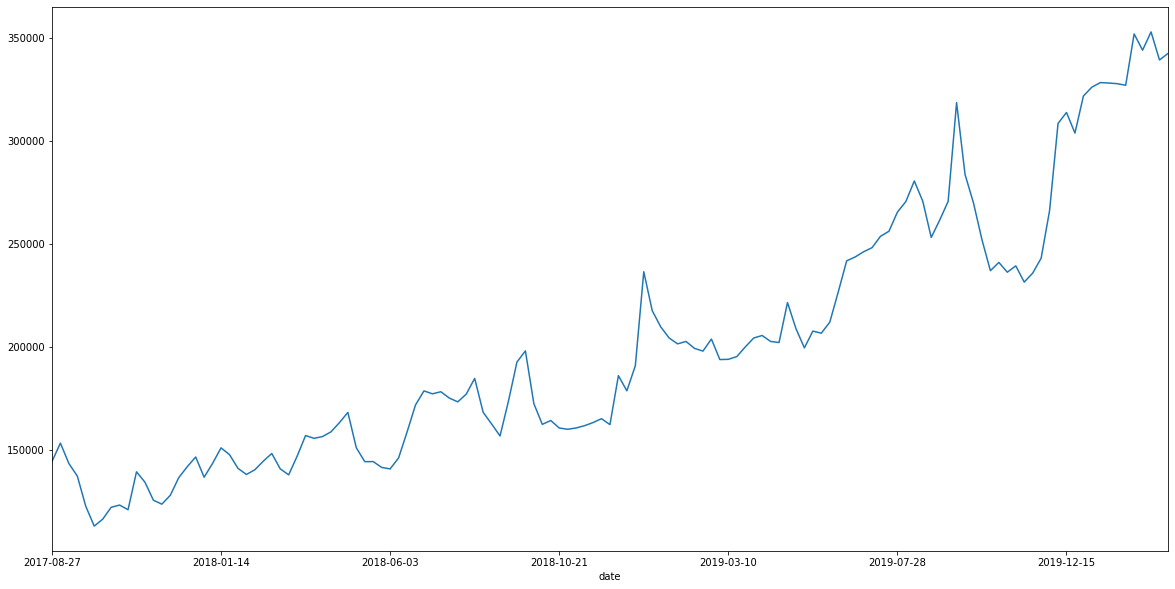

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots( figsize=(20, 10))
UchiageHanabi_trend.Streams.plot()

## 今回は、2019年6月30日以降の再生数を統計モデルを使って予測する。

In [0]:
#2019年を予測検証データに用いるため分ける
# 訓練用のデータ
train= UchiageHanabi_trend[ 
    (UchiageHanabi_trend.date <= "2019-06-30")].set_index("date")[["Streams"]]
# test（検証用のデータ)
test = UchiageHanabi_trend[UchiageHanabi_trend.date > "2019-06-30"].set_index("date")[["Streams"]]

### 自己回帰（Auto Regression）モデル
現在のデータは、過去のデータからどれだけ変化したかで表すことができるモデル。

現在のデータ = 過去データ + ランダムの変化量
### 移動平均(Moving Average)モデル

現在のデータを、平均値＋ある時点までのホワイトノイズ（満遍なく出現されるランダムな数字）の合計+それらを調整する定数で表現することができるモデル(移動平均の計算と異なることに注意！）

## それを合わせたのをARMAモデルと呼ぶ

→でもそれだと非定常性の時系列に対応できない。。。。
### 定常、非定常とは
続く...
## 非定常過程（ここでは和分過程と呼ぶ)に対しても推定できるようにするのがARIMAモデル
さらに、季節などといった周期性のあるものを捉えられるようにするために必要なのがSARIMAモデル

In [28]:
# statsmodels と言う、統計処理用のライブラリを用いる。
#(ver0.11でないと、不具合もあるため、バージョンを指定する。)
!pip install statsmodels==0.11


## 階差と、コレログラムをプロット

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


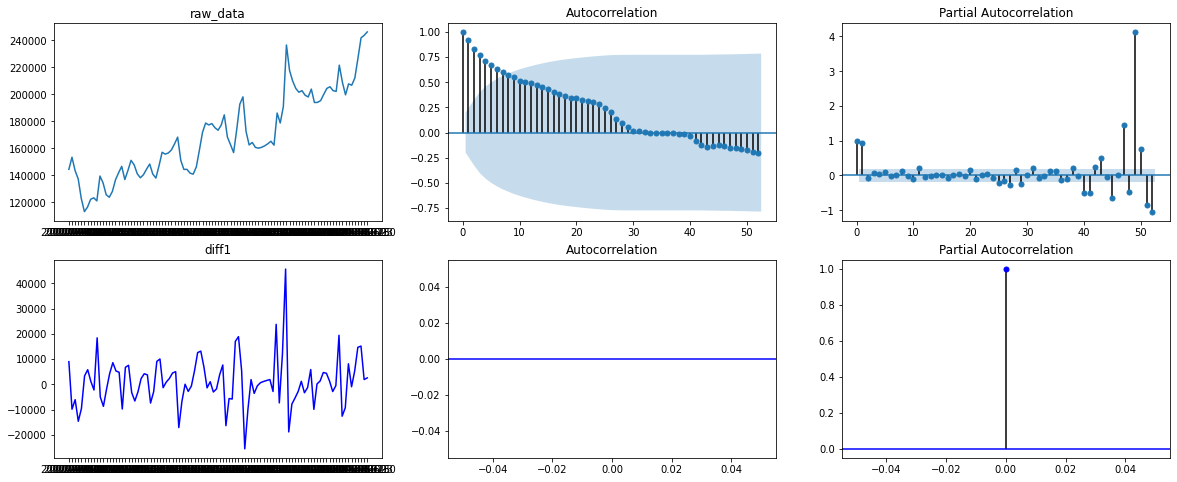

In [11]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
plt.rcParams["font.size"] = 10
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
axes = ax.flatten()
diff_color = "blue"
# 階差を取得
raw_data = train.Streams
train_diff1 = raw_data.diff()
axes[0].plot(raw_data)
axes[0].set_title("raw_data")
fig = sm.graphics.tsa.plot_acf(raw_data, lags=52, ax=axes[1])
fig = sm.graphics.tsa.plot_pacf(raw_data, lags=52, ax=axes[2])

axes[3].plot(train_diff1.dropna(), color=diff_color, alpha=1)
axes[3].set_title("diff1")
fig = sm.graphics.tsa.plot_acf(train_diff1, lags=52, ax=axes[4], color=diff_color)
fig = sm.graphics.tsa.plot_pacf(train_diff1, lags=52, ax=axes[5], color=diff_color)
# 左から、時系列グラフ、自己相関係数。偏自己相関係数（コレログラム）をプロットしたもの
# 下図は、階差をした上でのグラフとなっている。

In [12]:
# ADF検定(上の時系列が単位根過程であるかを検定する)
sm.tsa.stattools.adfuller(raw_data, 
                                   maxlag=None, 
                                   regression='c', 
                                   autolag='AIC', 
                                   store=False, 
                                   regresults=False)[1]


0.8668310007154707

この値が
**0.05の場合、単位根過程がなく、SARIMAが使えないので注意** 

## AIRMAで予測する

<Figure size 432x288 with 0 Axes>

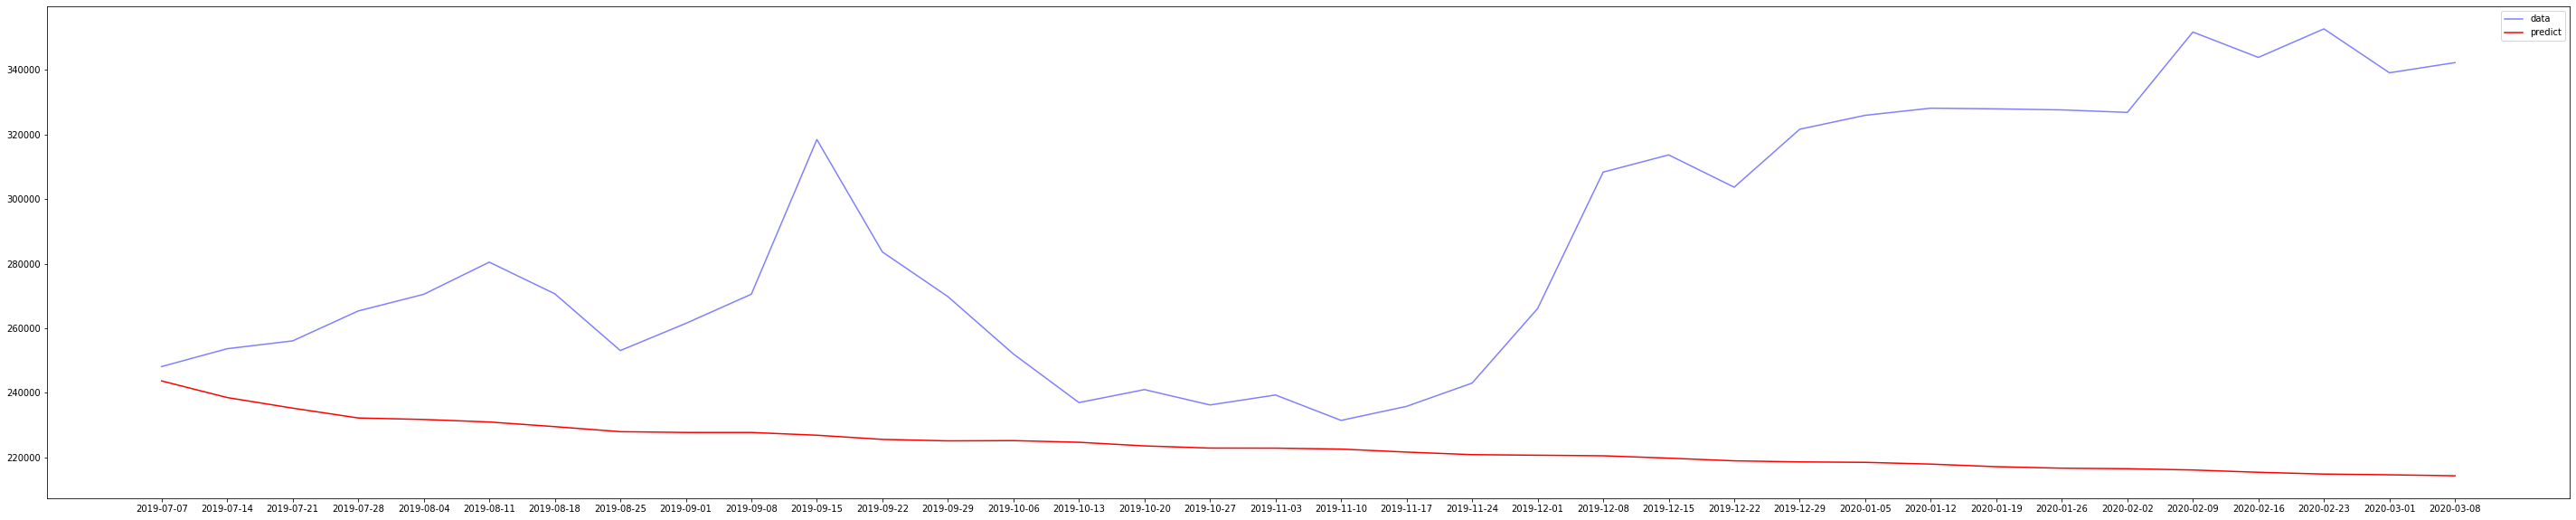

In [13]:
from statsmodels.tsa import arima_model
import matplotlib.pyplot as plt

results=arima_model.ARIMA(train.Streams.astype("float64").reset_index(drop=True),order = [5,0,5]).fit()
plt.clf()
# plt.plot(pd.concat([train.Streams, test.Streams]).reset_index(drop=True),c="blue", alpha=0.5)
# plt.plot(results.predict(start=1,end=133),c="red")
# plt.legend(["data","predict"])
predicted=results.predict(start=97,end=132).reset_index(drop=True)
predicted.index =test.Streams.index
plt.subplots( figsize=(50, 10))
plt.plot(test.Streams,c="blue", alpha=0.5)
plt.plot(predicted,c="red")
plt.legend(["data","predict"])

あまりうまく適合してない...。

## sarimaxで予測する。
- ARIMA 過程に季節調整(seasonal arrange 時系列データに季節といった周期性があるもの)を加える

In [14]:
model= sm.tsa.statespace.SARIMAX(train.Streams, order=(1,0,1),
                                 seasonal_order= (1,1, 2, 50),#(1,0,0)
                                 trend="ct",
                                 enforce_stationarity = False,
                                 enforce_invertibility=False)
results = model.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                                        SARIMAX Results                                        
Dep. Variable:                                 Streams   No. Observations:                   97
Model:             SARIMAX(1, 0, 1)x(1, 1, [1, 2], 50)   Log Likelihood                   0.000
Date:                                 Tue, 24 Mar 2020   AIC                             16.000
Time:                                         09:09:04   BIC                                nan
Sample:                                     08-27-2017   HQIC                               nan
                                          - 06-30-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.95e+04         -0       -inf      0.000    1.95e+04    1.95

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3053: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/eval_measures.py:370: RuntimeWarning: invalid value encountered in log
  return -2. * llf + np.log(nobs) * df_modelwc
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/eval_measures.py:394: RuntimeWarning: invalid value encountered in log
  return -2. * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1362: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/mlemodel.py:288

## テストデータの予測

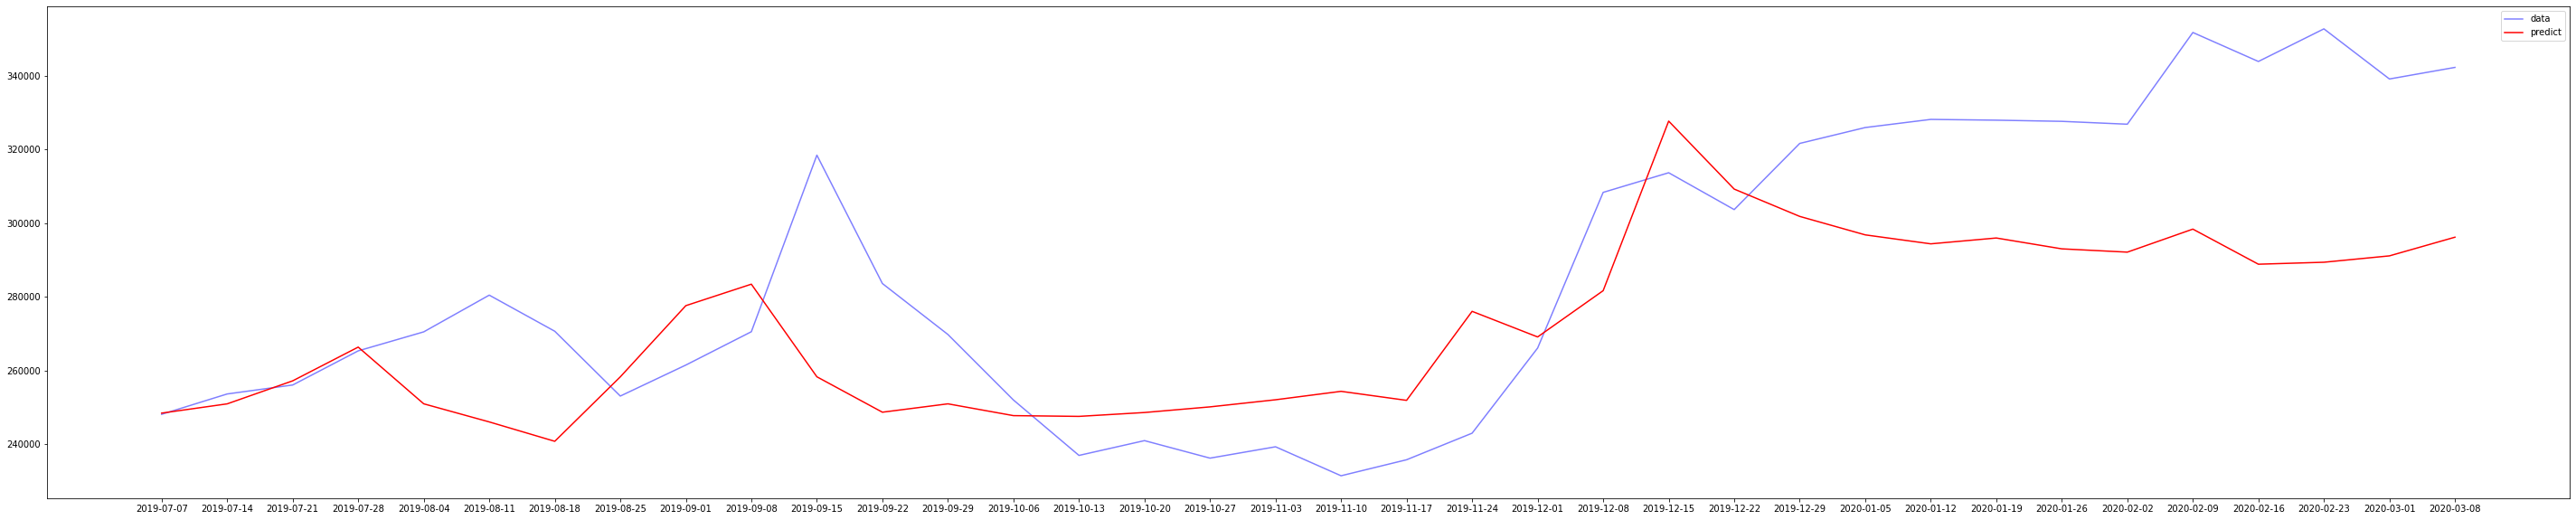

In [15]:
predicted=results.predict(start=97,end=132).reset_index(drop=True)
predicted.index =test.Streams.index
plt.subplots( figsize=(50, 10))
plt.plot(test.Streams,c="blue", alpha=0.5)
plt.plot(predicted,c="red")
plt.legend(["data","predict"])

## 全期間の予測

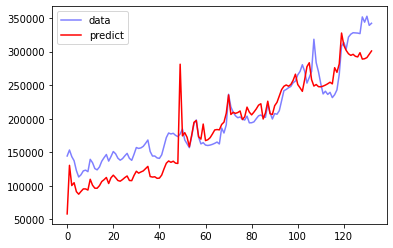

In [16]:
total_term=pd.concat([train.Streams, test.Streams])
plt.plot(total_term.reset_index(drop=True),c="blue", alpha=0.5)
plt.plot(results.predict(start=1,end=len(total_term)).reset_index(drop=True),c="red")
plt.legend(["data","predict"])

In [18]:
results.mle_retvals # converged がTrue になっていること(最尤法が収束していること)を確認

{'converged': True,
 'fcalls': 9,
 'fopt': -0.0,
 'gopt': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'iterations': 0,
 'warnflag': 0}

## 任意課題

## sarimaxのパラメータを最適化する
- パラメータは７つある。（ ARIMAX用のパラメータ 3つ + 季節調整用のARIMA パラメータ 3つ　+ 季節周期 1つ）
- そのうち、どのパラメータの組み合わせが最適なのかをAICと言う指標を使う(参考：https://bellcurve.jp/statistics/blog/15754.html　指標が小さいほど、有用である可能性が高い)


In [0]:
import itertools
p = [0,3]
d = [0,1]
q = [0,5]
sp = [0,1]
sd = [0,1]
sq = [0,2]
pdq = list(itertools.product(p, d, q))
# P, D, Q, 季節調整用 SP, SD, SQ　の組み合わせを列挙するリストを作成すると同時に、最後の　s = 52　を決め打ちでつけている。
seasonal_pdq = [[x[0], x[1], x[2], x[3],x[4],x[5], 52] for x in list(itertools.product(p,d,q,#))]
                                                                     sp, sd, sq))]
print(seasonal_pdq,f"配列長は{len(seasonal_pdq)}")

[[0, 0, 0, 0, 0, 0, 52], [0, 0, 0, 0, 0, 2, 52], [0, 0, 0, 0, 1, 0, 52], [0, 0, 0, 0, 1, 2, 52], [0, 0, 0, 1, 0, 0, 52], [0, 0, 0, 1, 0, 2, 52], [0, 0, 0, 1, 1, 0, 52], [0, 0, 0, 1, 1, 2, 52], [0, 0, 5, 0, 0, 0, 52], [0, 0, 5, 0, 0, 2, 52], [0, 0, 5, 0, 1, 0, 52], [0, 0, 5, 0, 1, 2, 52], [0, 0, 5, 1, 0, 0, 52], [0, 0, 5, 1, 0, 2, 52], [0, 0, 5, 1, 1, 0, 52], [0, 0, 5, 1, 1, 2, 52], [0, 1, 0, 0, 0, 0, 52], [0, 1, 0, 0, 0, 2, 52], [0, 1, 0, 0, 1, 0, 52], [0, 1, 0, 0, 1, 2, 52], [0, 1, 0, 1, 0, 0, 52], [0, 1, 0, 1, 0, 2, 52], [0, 1, 0, 1, 1, 0, 52], [0, 1, 0, 1, 1, 2, 52], [0, 1, 5, 0, 0, 0, 52], [0, 1, 5, 0, 0, 2, 52], [0, 1, 5, 0, 1, 0, 52], [0, 1, 5, 0, 1, 2, 52], [0, 1, 5, 1, 0, 0, 52], [0, 1, 5, 1, 0, 2, 52], [0, 1, 5, 1, 1, 0, 52], [0, 1, 5, 1, 1, 2, 52], [3, 0, 0, 0, 0, 0, 52], [3, 0, 0, 0, 0, 2, 52], [3, 0, 0, 0, 1, 0, 52], [3, 0, 0, 0, 1, 2, 52], [3, 0, 0, 1, 0, 0, 52], [3, 0, 0, 1, 0, 2, 52], [3, 0, 0, 1, 1, 0, 52], [3, 0, 0, 1, 1, 2, 52], [3, 0, 5, 0, 0, 0, 52], [3, 0, 5, 0, 0,

In [0]:
def sarimax_fit(train_data,param):
    try:
        result = sm.tsa.statespace.SARIMAX(train_data,
                                        order=(param[0], param[1], param[2]),
                                   seasonal_order=(param[3], param[4], param[5],param[6]),
                                        enforce_invertibility = False, enforce_stationarity = False,
                                          trend="ct"
                                          ).fit()
        return result
    except Exception as e:
        print(e)
        return 0

In [0]:

import joblib
res_list = joblib.Parallel(n_jobs=-1, verbose=10)([joblib.delayed(sarimax_fit)(train.Streams,param) for param in seasonal_pdq])
 
# # AICが小さくなる順にのパラメータの組み合わせを並べ変え
res_list

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   22.5s
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: 

CPU times: user 1min 5s, sys: 3min 3s, total: 4min 8s
Wall time: 4min 40s


[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  4.7min finished


### AICを取り出す

In [0]:
best_aic=1000
best_col = -1
for i,res in enumerate(res_list):
    if best_aic > res.aic:
        best_aic = res.aic
        
        print(res.aic)
        best_col = i
## もっとも少ないAIC をもつモデルを代入
best_sarimax= res_list[best_col]
aic_df = pd.DataFrame({"params": seasonal_pdq, "aic": [r.aic if r == 0 else 0 for r in res_list]})
aic_df.sort_values("aic", inplace=True)
aic_df

8.0
4.0


In [0]:
aic_df.head(10)

In [0]:
import itertools
# p = [4,5]
# d = [0,1,2]
# q = [3,4,5]
sp = range(3)
sd = range(2)
sq = range(3)
# pdq = list(itertools.product(p, d, q))
# trial_num = len(p_list) * len(d_list) * len(q_list) *len(sp_list) * len(sd_list) * len(sq_list)

use_columns = ["p", "d", "q", "AIC"]
step_cnt = 0
train_data = raw_data

info_df = pd.DataFrame(columns=use_columns)
for i,param in enumerate(pdq):
    model = sm.tsa.statespace.SARIMAX(train.Streams, order=param, enforce_invertibility=False,
#                                               trend='t'
                                      
                                     )
    p,d,q = param

    try:
        
        res = model.fit(disp=False)
        info_df = info_df.append(pd.Series([p,d,q,res.aic], index=use_columns),ignore_index=True)
    except:
        pass
    print(f"iter {i} finished... param :{param}, aic{res.aic}")


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 0 finished... param :(4, 0, 3), aic14470.473082995488


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 1 finished... param :(4, 0, 4), aic14422.988875771864


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 2 finished... param :(4, 0, 5), aic14378.301322314604


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 3 finished... param :(4, 1, 3), aic14326.940804186019


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 4 finished... param :(4, 1, 4), aic14336.548555424903


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 5 finished... param :(4, 1, 5), aic14261.905609171314
iter 6 finished... param :(4, 2, 3), aic14436.371483751755


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 7 finished... param :(4, 2, 4), aic14409.605093594371


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 8 finished... param :(4, 2, 5), aic14379.079233190983


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 9 finished... param :(5, 0, 3), aic14434.226485915256


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 10 finished... param :(5, 0, 4), aic14354.932488315348


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 11 finished... param :(5, 0, 5), aic14352.487057624134


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 12 finished... param :(5, 1, 3), aic14276.780453344385


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 13 finished... param :(5, 1, 4), aic14227.51366391924


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 14 finished... param :(5, 1, 5), aic14231.896564833105


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 15 finished... param :(5, 2, 3), aic14400.208135195775


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 16 finished... param :(5, 2, 4), aic14342.73756882191
iter 17 finished... param :(5, 2, 5), aic14356.469587458154


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
